# Liver analysis 002

**Date**: 2020-09-10<br>
**Author**: Alma Andersson<br>
**Description**:<br>

Analysis of a single liver sample, mainly to illustrate certain concepts and show what sort of analysis that can be made. The analysis include plotting of gene expression levels as a function of distance from a vein (of a given type), classification of veins based on their surrounding gene expression, and a survey of how the spot expression compares to certain types of tissue.



## Setup

Load data the necessary packages and data for the analysis, also specify certain constants which will be used throughout the analysis.

In [1]:
%load_ext autoreload
%autoreload 2


In [116]:
import pandas as pd
import numpy as np
import anndata as ad

from skmisc.loess import loess

import os
import os.path as osp
from os import listdir

import matplotlib.pyplot as plt

from PIL import Image

from functools import reduce

from scipy.spatial.distance import cdist

import utils as ut


In [117]:
DATA_DIR = "/home/alma/w-projects/help/franzi/repo/data/h5ad-files/"

PTHS = list(filter(lambda x: x.split(".")[-1] == "h5ad",os.listdir(DATA_DIR)))
PTHS = {p.split(".")[0]:osp.join(DATA_DIR,p) for p in PTHS }

In [271]:
#exclude = ["CN65-E1","CN65-C1","CN65-C2","CN65-D2","CN16-D1"]
exclude = []
data_set = {n:ad.read_h5ad(p) for n,p in PTHS.items()}

for ex in exclude:
    data_set.pop(ex)

data_set

{'CN65-C1': AnnData object with n_obs × n_vars = 647 × 8958
     obs: '_x', '_y', 'x', 'y'
     var: 'gene'
     uns: 'img', 'mask'
     obsm: 'vein_distances',
 'CN73-D1': AnnData object with n_obs × n_vars = 684 × 8045
     obs: '_x', '_y', 'x', 'y'
     var: 'gene'
     uns: 'img', 'mask'
     obsm: 'vein_distances',
 'CN65-C2': AnnData object with n_obs × n_vars = 626 × 8958
     obs: '_x', '_y', 'x', 'y'
     var: 'gene'
     uns: 'img', 'mask'
     obsm: 'vein_distances',
 'CN16-E1': AnnData object with n_obs × n_vars = 1348 × 9334
     obs: '_x', '_y', 'x', 'y'
     var: 'gene'
     uns: 'img', 'mask'
     obsm: 'vein_distances',
 'CN73-C1': AnnData object with n_obs × n_vars = 673 × 8045
     obs: '_x', '_y', 'x', 'y'
     var: 'gene'
     uns: 'img', 'mask'
     obsm: 'vein_distances',
 'CN65-D1': AnnData object with n_obs × n_vars = 663 × 8958
     obs: '_x', '_y', 'x', 'y'
     var: 'gene'
     uns: 'img', 'mask'
     obsm: 'vein_distances',
 'CN16-D1': AnnData object with n

In [258]:
# specify path to folder where gene lists are kept
gene_list_pth = "/home/alma/w-projects/help/franzi/repo/data/gene-lists/veins"

In [272]:
use_short_filter = True

pths = listdir(gene_list_pth)
if use_short_filter:
    pths = list(filter(lambda x: "short" in x,pths))
else:
    pths = list(filter(lambda x: "short" not in x,pths))
# read gene lists
genes = dict()

for filename in pths:
    name = '.'.join(filename.split(".")[0:-1])
    with open(osp.join(gene_list_pth,filename),"r+") as f:
        _gs = f.readlines()
        _gs = [x.replace("\n","") for x in _gs]
        genes.update({name:_gs})
        
# create an additional entry called "all" by joining 
# all existing lists
genes["all"] = reduce(lambda x,y : x + y,list(genes.values()))

In [121]:
# CONSTANTS

# SCALE_FACTOR : scaling factor px to um
SCALE_FACTOR = 0.138

Visualize the data to make sure everything looks as expected

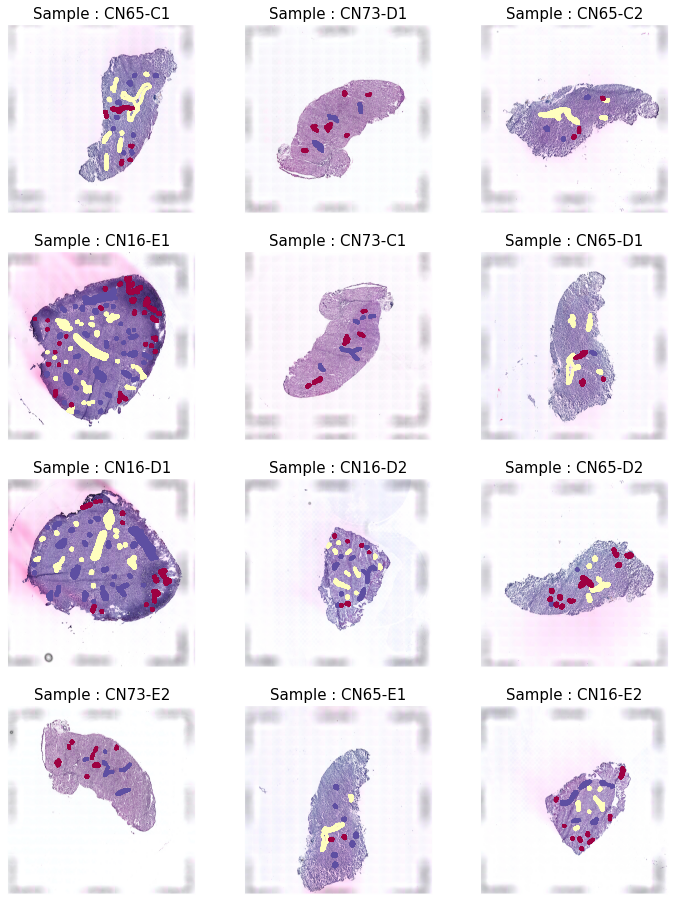

In [273]:
n_veins = len(data_set)
spot_size = 20

fig,ax = ut.get_figure(n_veins,n_cols = 3, side_size = side_size)

for k,(sample_id,data) in enumerate(data_set.items()):
    
    ut.plot_veins(ax[k],data,show_image=True)
    ax[k].set_title("Sample : {}".format(sample_id),
                   fontsize = 15,
                   )
    
plt.show()

In [274]:
for sample,data in data_set.items():
    log_ratio = np.log(data.obsm["vein_distances"].dist_type_central) -\
    np.log(data.obsm["vein_distances"].dist_type_portal)
    data_set[sample].obsm["vein_distances"]["log(central/portal)"] = log_ratio

## Analysis : Expression by distance

Model gene expression as a function of the distance to the nearest gene. We use loess regression to get an approximation of the curve that describe the trends in the data. Envelopes (blue) represent 1 standard error.

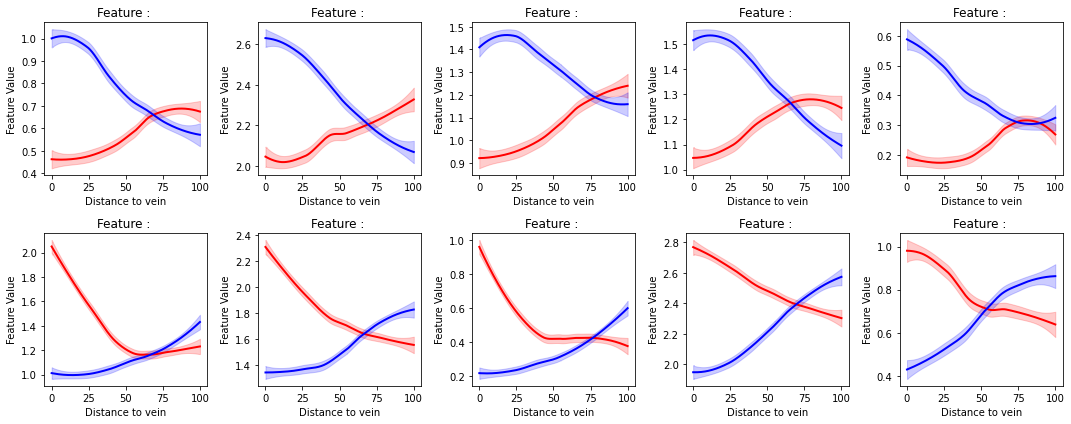

In [275]:

# set vein type to plot
vein_type = "all"

# set to true if plots should share y-axis
share_y = False

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = 100

# which genes to be assessed
vein_genes = genes[vein_type]

# distance values to use

colormap = dict(central = {"envelope":"red",
                           "fitted":"red",
                           "background":"red"},
               portal = {"envelope":"blue",
                         "fitted":"blue",
                         "background":"blue"},
               )

fig,ax = ut.get_figure(len(vein_genes),
                       n_cols = 5,
                       side_size = 3,
                      )

# iterate over each gene
for k,gene in enumerate(vein_genes):
    
    
    for vt in ["central","portal"]:

        xs = np.array([])
        ys = np.array([])

        for data in data_set.values():
            if gene not in data.var.gene.values:
                print("can't find {}".format(gene))
                continue

            min_dist = data.obsm["vein_distances"]["dist_type_" + vt].values
            xs = np.append(xs,min_dist)
            ys = np.append(ys,data.obs_vector(gene))
        
        smoothed = ut.smooth_fit(xs,ys,dist_thrs=dist_thrs)
        ut.plot_expression_by_distance(ax[k],
                                       data = smoothed,
                                       curve_label = vt,
                                       color_scheme = colormap[vt],
                                       include_background = False,
                                      )


fig.tight_layout()

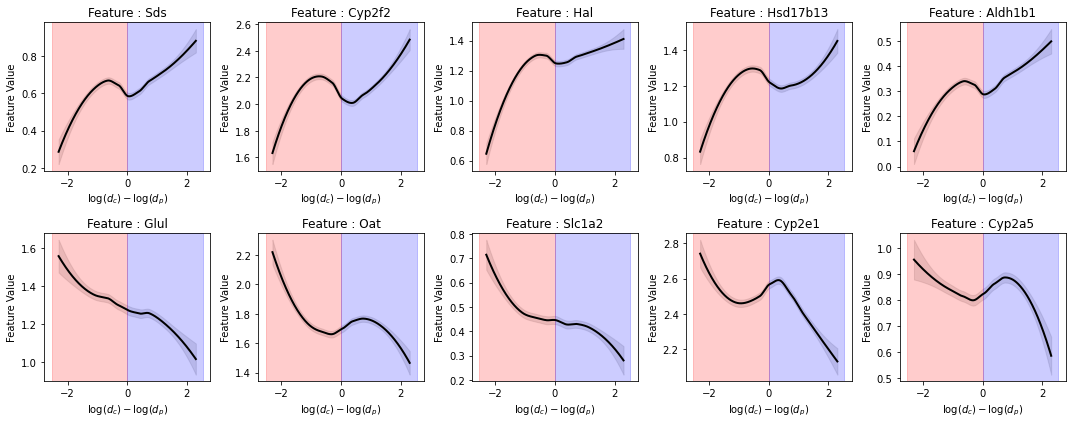

In [257]:

# set vein type to plot
vein_type = "all"

# set to true if plots should share y-axis
share_y = False

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = np.log(10)

# which genes to be assessed
vein_genes = genes[vein_type]


fig,ax = ut.get_figure(n_elements=len(vein_genes),
                       n_cols = 5,
                       side_size = 3,
                      )
# --- plot settings

# iterate over each gene
#for k,gene in enumerate(vein_genes):
for k,gene in enumerate(vein_genes):

    xs = np.array([])
    ys = np.array([])

    for data in data_set.values():
        if gene not in data.var.gene.values:
            continue

        dist = data.obsm["vein_distances"]["log(central/portal)"].values
        xs = np.append(xs,dist)
        ys = np.append(ys,data.obs_vector(gene))

    smoothed = ut.smooth_fit(xs,ys,dist_thrs=dist_thrs)
    ut.plot_expression_by_distance(ax[k],
                                   smoothed,
                                   flavor ="logodds",
                                   feature = gene,
                                   color_scheme = {"envelope":"gray"},
                                   include_background = False,
                                 )

fig.tight_layout()
plt.show()

In [129]:
# set vein type to plot
vein_type = "all"

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = 100

# which genes to be assessed
vein_genes = genes[vein_type]

ints = dict()

# iterate over each gene
for k,gene in enumerate(vein_genes):
    
    xs = np.array([])
    ys = np.array([])

    for data in data_set.values():
        if gene not in data.var.gene.values:
            continue

        dist = data.obsm["vein_distances"]["log(central/portal)"].values
        xs = np.append(xs,dist)
        ys = np.append(ys,data.obs_vector(gene))
    
    smoothed = ut.smooth_fit(xs,ys,dist_thrs=dist_thrs)
    
    leq0 = smoothed[0] <= 0
    geq0 = smoothed[0] > 0 
    ints[gene] = dict(left = np.trapz(smoothed[2][leq0],smoothed[0][leq0]),
                      right = np.trapz(smoothed[2][geq0],smoothed[0][geq0]),
                     )
    

KeyboardInterrupt: 

In [ ]:
top_genes = pd.Index([])
gene_diff = pd.DataFrame(ints).T
n_top = 10

gene_diff["diff"] = gene_diff.left-gene_diff.right
for order in [True,False]:
    gene_diff = gene_diff.sort_values(by = "diff",ascending=order)
    top_genes = top_genes.union(gene_diff.head(n_top).index)
    gene_diff.head(n_top)

## Analysis : Classification

Begin by assembling representative (mean expression) vectors for neighborhoods around respective vein type and each individual vein. Then proceed to train a predictor (Logistic Regression) and see how it performs on the given data (this is just a prototype).

### Prepare data
Create the necessary mean expression profiles

In [276]:
import utils as ut
vein_data = ut.VeinData(data_set = data_set,
                        radius = 70,
                        use_genes = genes["all"],
                        weight_by_distance = True,
                        sigma = 20,
                        verbose = False,
                       )

model = ut.Model(vein_data,
                 verbose=False)


### Train and Predict with classifier

use the `LogisticRegression` module from `sklearn` to create a classifier (binary classification into portal and central veins). We use a l2 penalty to reduce the extent of overfitting and also prevent the weights to blow up.

In [277]:
results = model.k_fold_validation(k=1,
                                  exclude_class="unknown",
                                  by = "sample",
                                  verbose = False,
                                 )
display(results)
print("Average Accuracy {}".format(results["accuracy"].mean()))

[INFO] : >In Test | some excluded classes not present in the data
[INFO] : >In Test | some excluded classes not present in the data
[INFO] : >In Test | some excluded classes not present in the data


pred_on                                           train_on  accuracy
0   CN16-E2  CN65-C1, CN73-D1, CN65-C2, CN16-E1, CN73-C1, C...  1.000000
1   CN65-E1  CN65-C1, CN73-D1, CN65-C2, CN16-E1, CN73-C1, C...  0.222222
2   CN73-E2  CN65-C1, CN73-D1, CN65-C2, CN16-E1, CN73-C1, C...  0.857143
3   CN65-D2  CN65-C1, CN73-D1, CN65-C2, CN16-E1, CN73-C1, C...  0.714286
4   CN16-D2  CN65-C1, CN73-D1, CN65-C2, CN16-E1, CN73-C1, C...  0.947368
5   CN16-D1  CN65-C1, CN73-D1, CN65-C2, CN16-E1, CN73-C1, C...  0.864865
6   CN65-D1  CN65-C1, CN73-D1, CN65-C2, CN16-E1, CN73-C1, C...  1.000000
7   CN73-C1  CN65-C1, CN73-D1, CN65-C2, CN16-E1, CN65-D1, C...  0.900000
8   CN16-E1  CN65-C1, CN73-D1, CN65-C2, CN73-C1, CN65-D1, C...  0.891304
9   CN65-C2  CN65-C1, CN73-D1, CN16-E1, CN73-C1, CN65-D1, C...  0.666667
10  CN73-D1  CN65-C1, CN65-C2, CN16-E1, CN73-C1, CN65-D1, C...  1.000000
11  CN65-C1  CN73-D1, CN65-C2, CN16-E1, CN73-C1, CN65-D1, C...  0.705882

Average Accuracy 0.8141447872501849


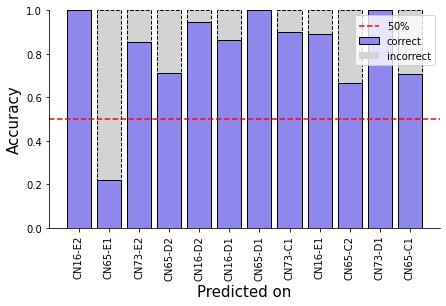

In [278]:
fig,ax = ut.visualize_prediction_result(results)

Finally we can visualize the prediction on the tissue, showing the predicted and true labels for respective vein

In [279]:
results = model.k_fold_validation(k=1,
                                  exclude_class="unknown",
                                  by = "individual",
                                  verbose = False,
                                 )

[INFO] : >In Test | some excluded classes not present in the data


In [280]:
results

pred_on    train_on  accuracy
0    CN16  CN65, CN73  0.807018
1    CN73  CN65, CN16  0.848485
2    CN65  CN73, CN16  0.613636

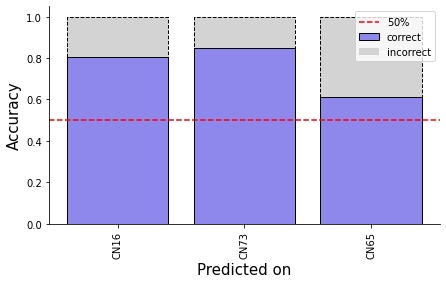

In [281]:
fig,ax = ut.visualize_prediction_result(results)

## Prediction on unknown veins

In [282]:
model.fit(train_on = "all",
          verbose=True,
          exclude_class="unknown")

predict = model.predict(predict_on="all",
                        exclude_class=["portal","central"],
                        return_probs = True,
                       )


[INFO] : Training on samples: all
[INFO] : Accuracy on training data is >> 87.435%


Vein : CN16-E1_46 | P(central) : 0.06597980365618494 | P(portal) : 0.9340201963438151


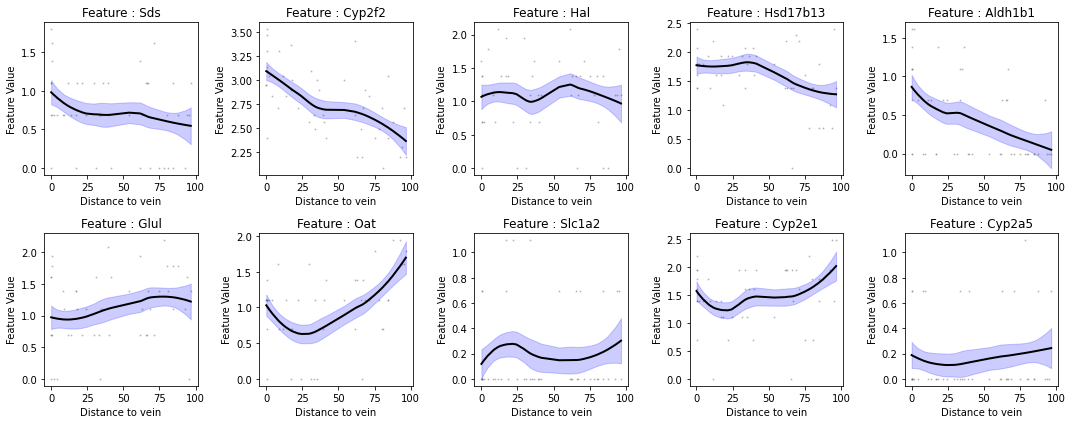

Vein : CN16-E1_47 | P(central) : 0.698996273571733 | P(portal) : 0.30100372642826706


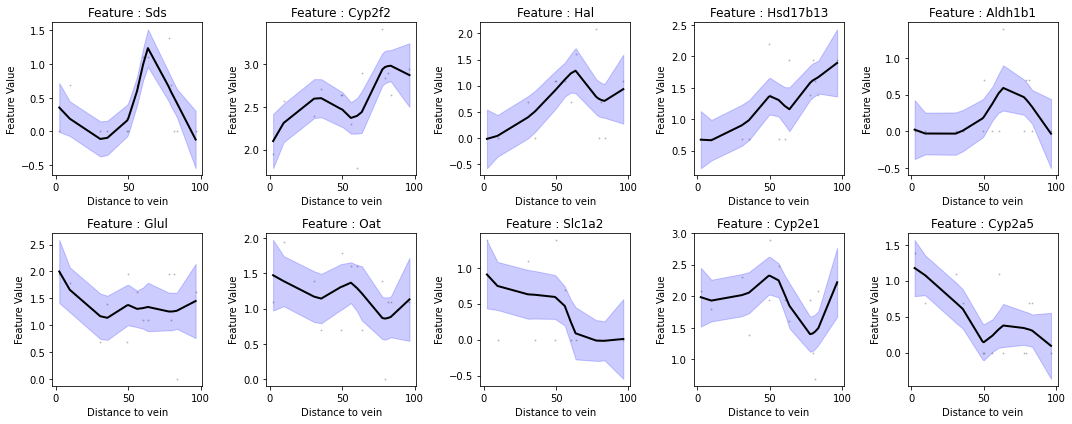

Vein : CN16-E1_48 | P(central) : 0.5355091863663217 | P(portal) : 0.46449081363367833


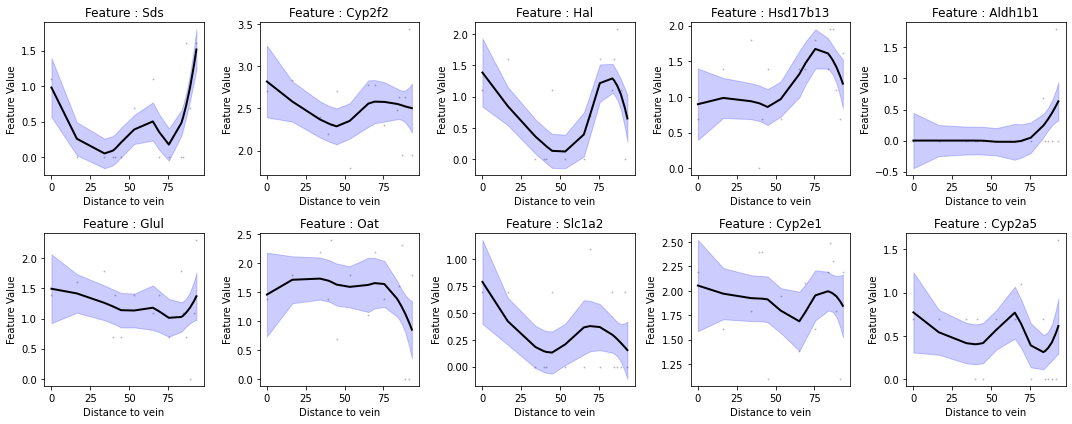

Vein : CN16-E1_49 | P(central) : 0.19969470816451018 | P(portal) : 0.8003052918354898


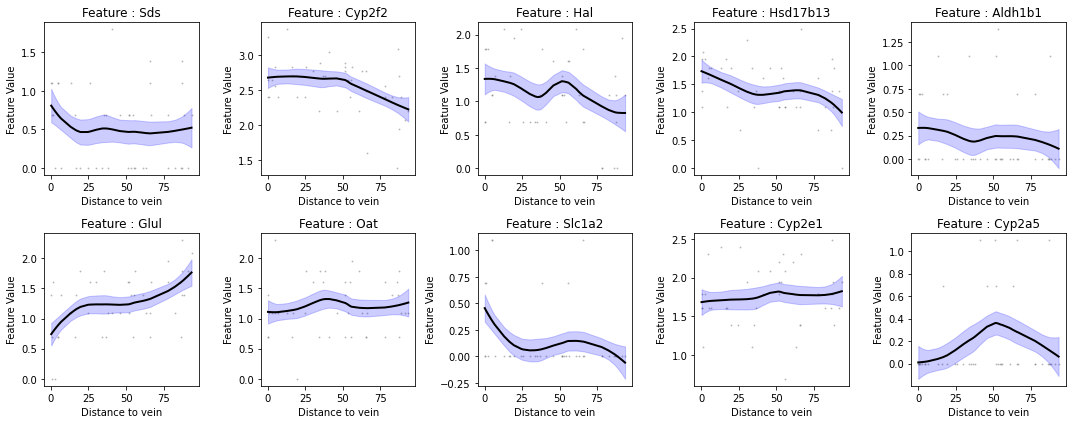

Vein : CN16-E1_50 | P(central) : 0.6502045806642608 | P(portal) : 0.3497954193357392


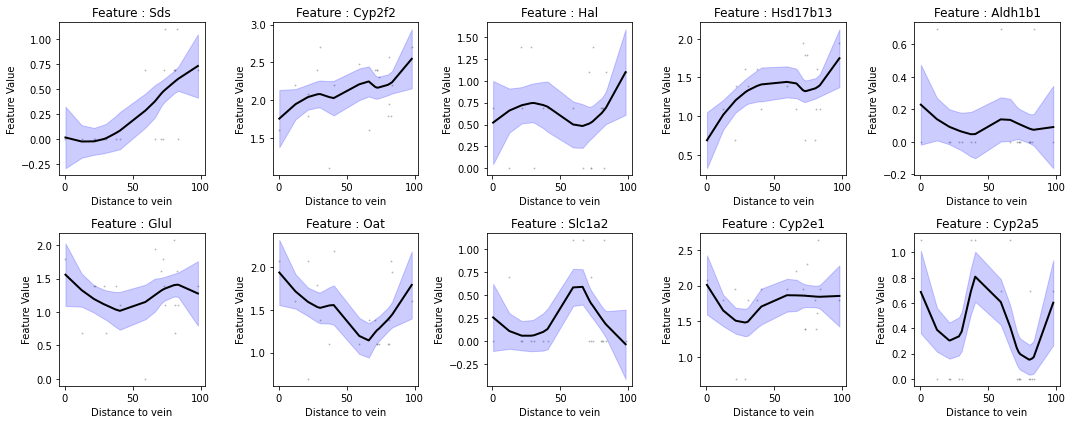

Vein : CN16-E1_51 | P(central) : 0.1622007516947359 | P(portal) : 0.8377992483052641


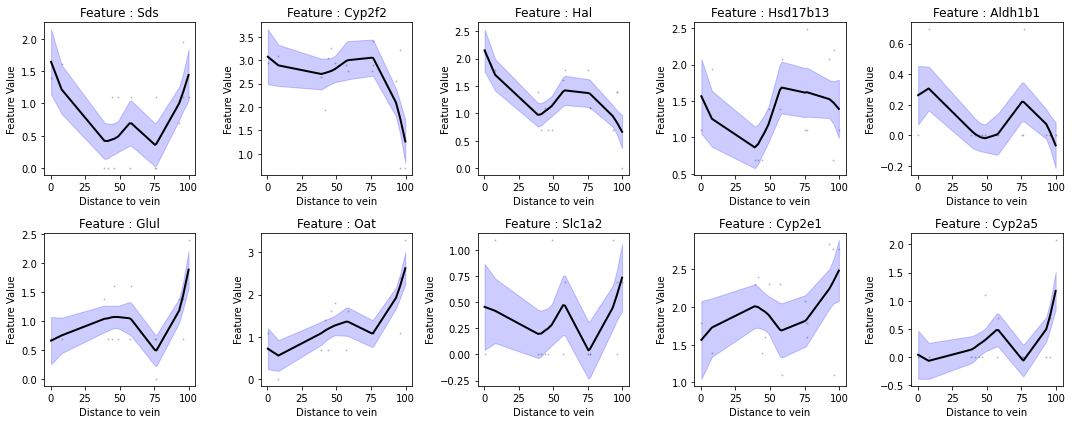

Vein : CN16-E1_52 | P(central) : 0.7287477850600518 | P(portal) : 0.2712522149399482


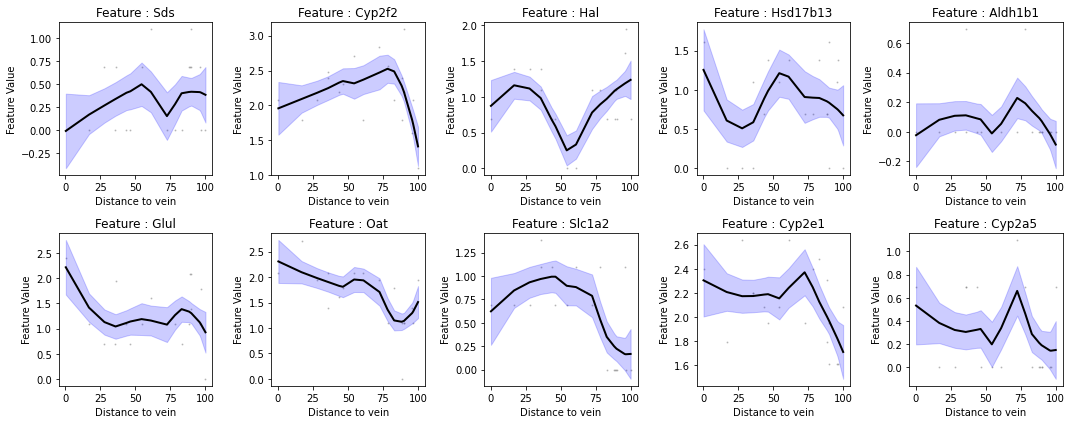

Vein : CN16-E1_53 | P(central) : 0.4515667387243658 | P(portal) : 0.5484332612756342


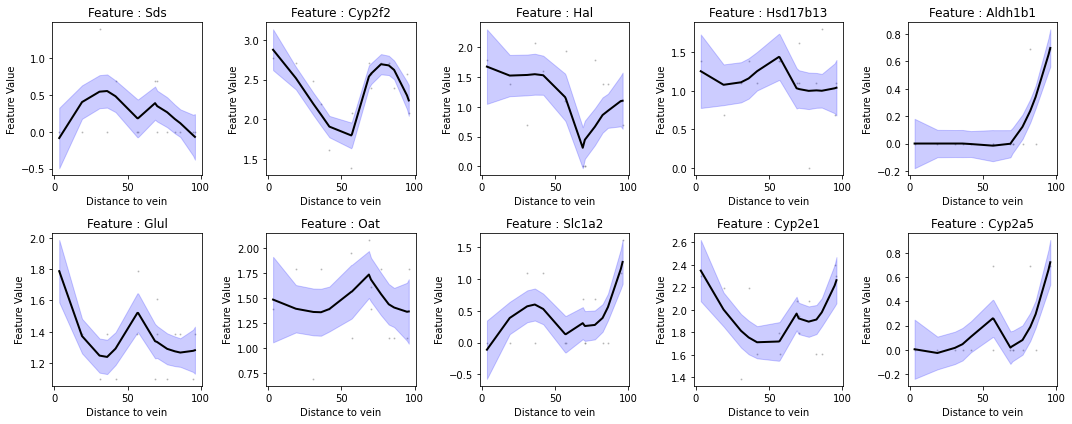

Vein : CN16-E1_54 | P(central) : 0.5366254784121662 | P(portal) : 0.4633745215878338


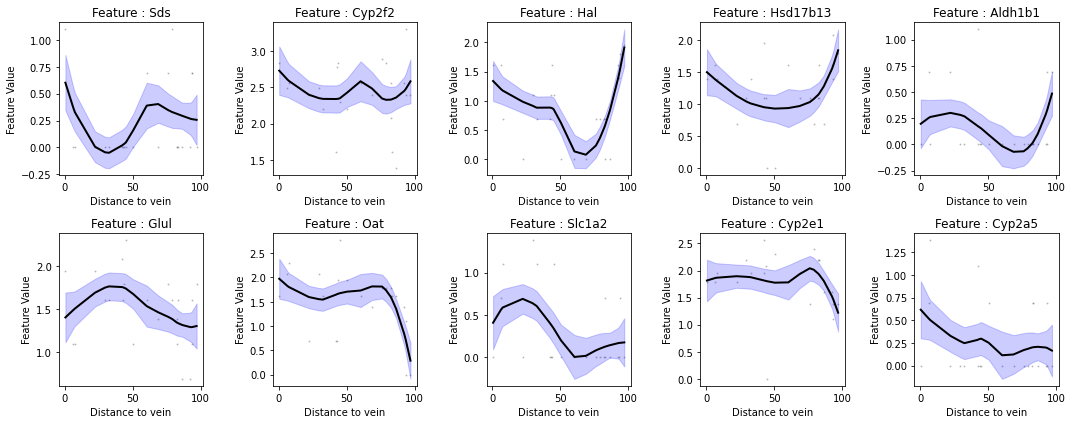

Vein : CN16-E1_55 | P(central) : 0.39928136961405636 | P(portal) : 0.6007186303859436


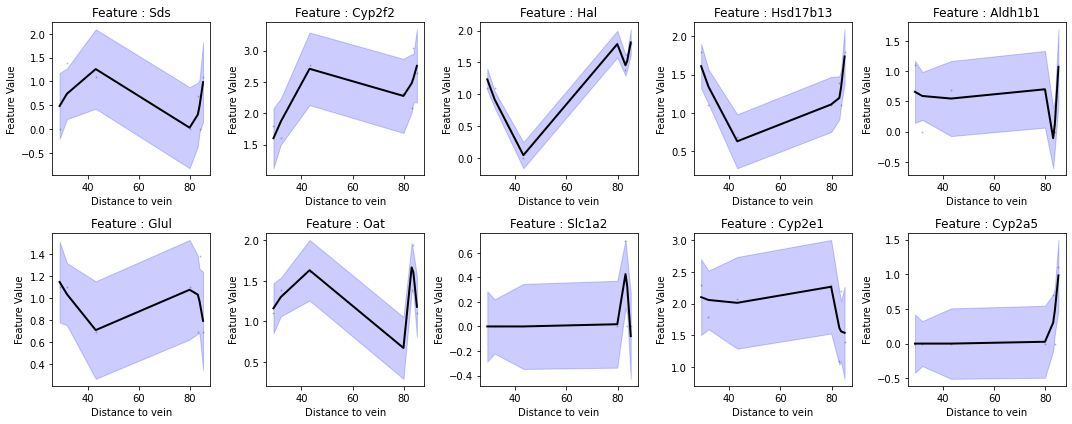

Vein : CN16-E1_56 | P(central) : 0.4389108440686609 | P(portal) : 0.5610891559313391


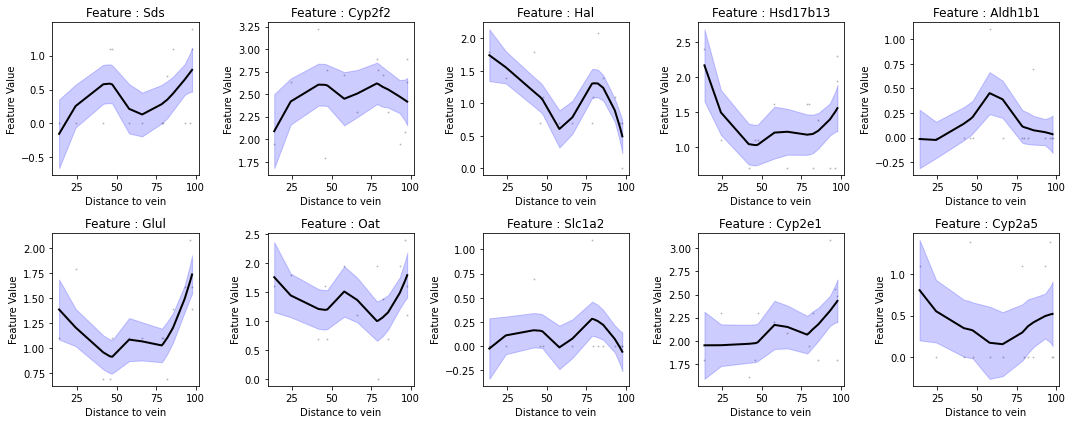

Vein : CN16-E1_57 | P(central) : 0.5902931720519415 | P(portal) : 0.40970682794805846


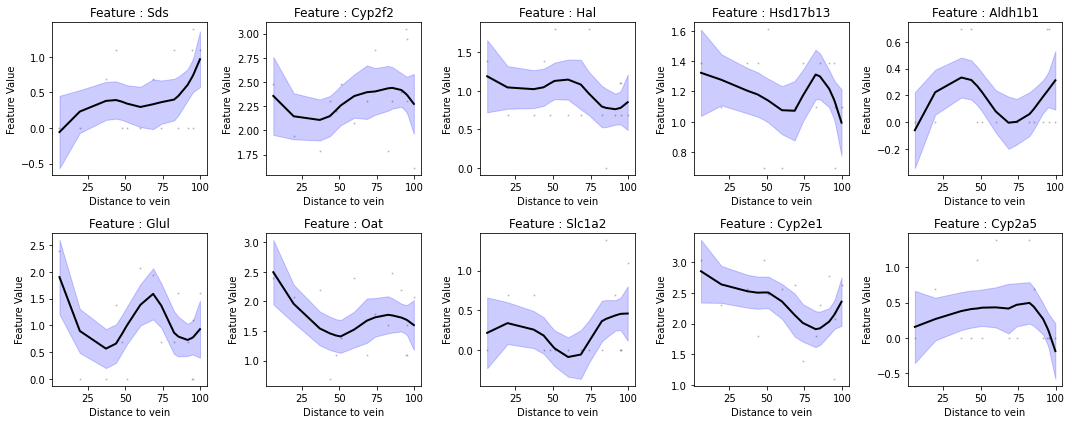

Vein : CN16-E1_58 | P(central) : 0.5269552856955708 | P(portal) : 0.4730447143044292


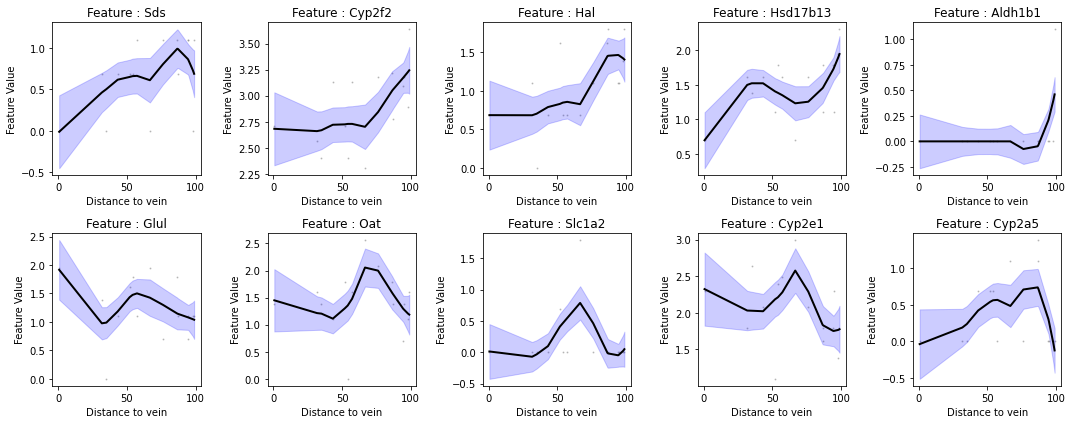

Vein : CN16-E1_59 | P(central) : 0.20809218720464417 | P(portal) : 0.7919078127953558


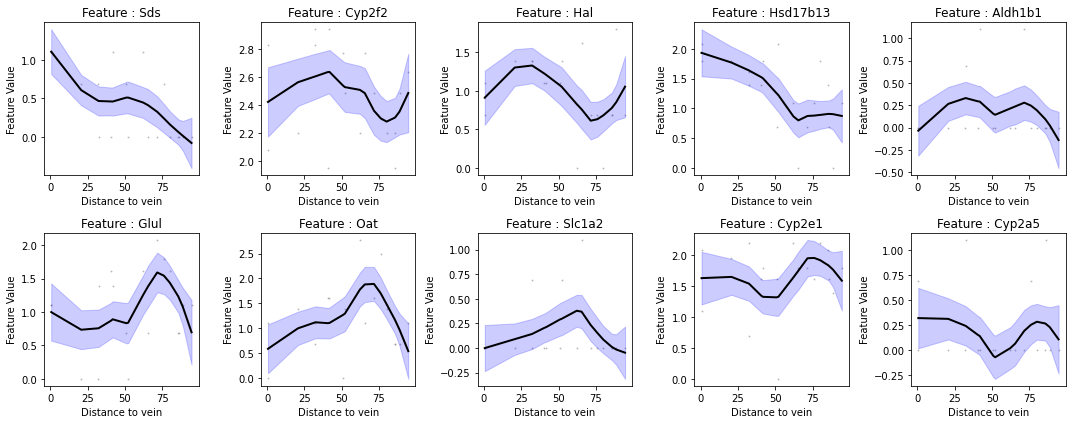

Vein : CN16-E1_60 | P(central) : 0.25629316514207157 | P(portal) : 0.7437068348579284


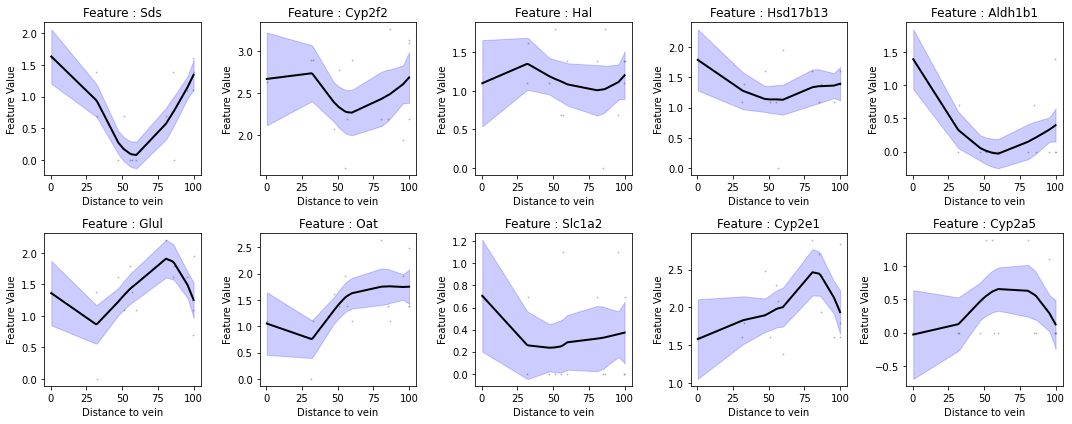

Vein : CN16-E1_61 | P(central) : 0.5663028352987303 | P(portal) : 0.43369716470126973


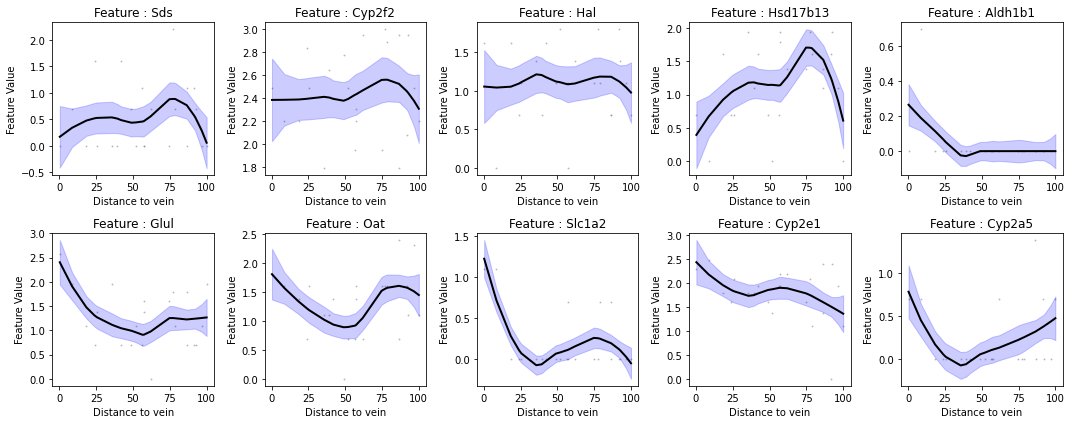

Vein : CN16-E1_62 | P(central) : 0.25748121049988093 | P(portal) : 0.7425187895001191


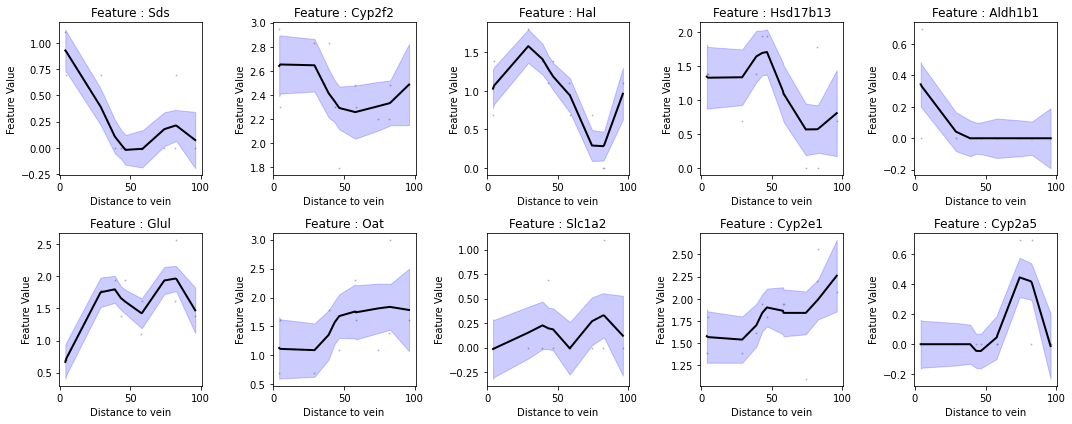

Vein : CN16-E1_63 | P(central) : 0.7424179795118635 | P(portal) : 0.25758202048813655


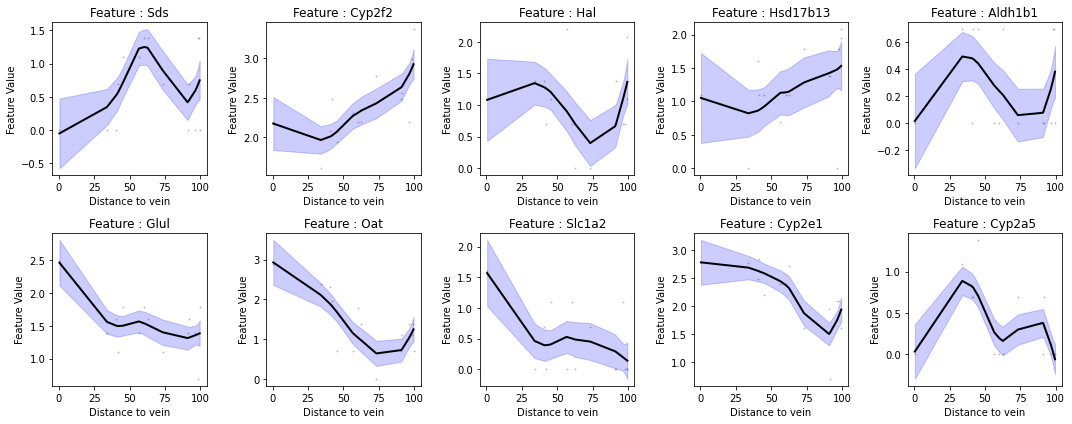

Vein : CN16-E1_64 | P(central) : 0.493860929449208 | P(portal) : 0.506139070550792


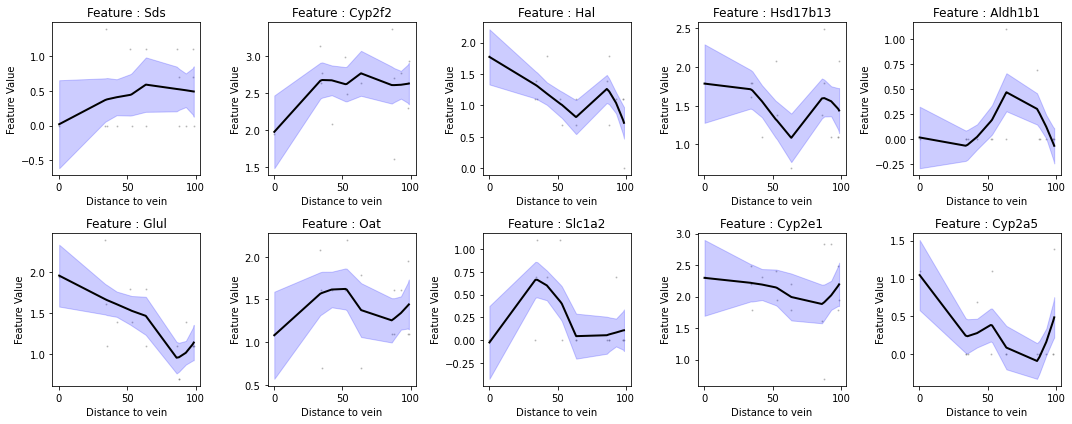

Vein : CN16-E1_65 | P(central) : 0.5156451695138204 | P(portal) : 0.48435483048617956


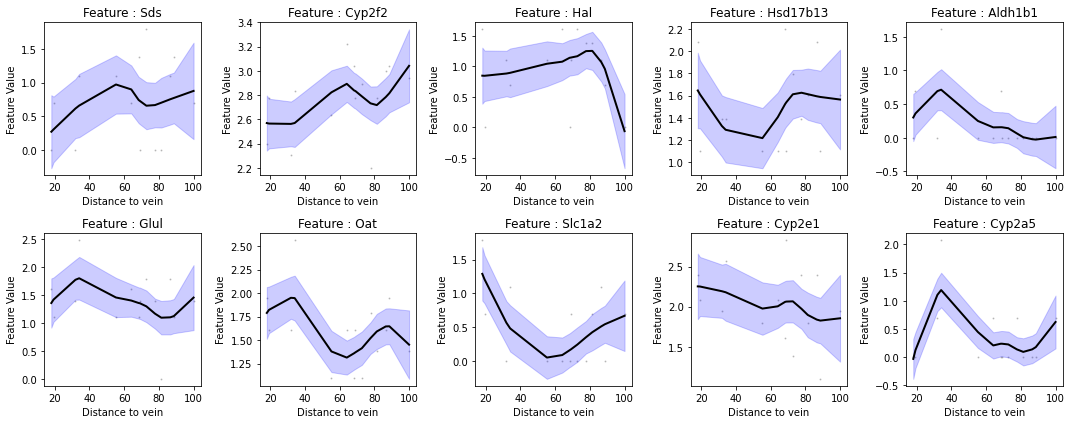

Vein : CN16-E1_66 | P(central) : 0.20628830246782248 | P(portal) : 0.7937116975321775


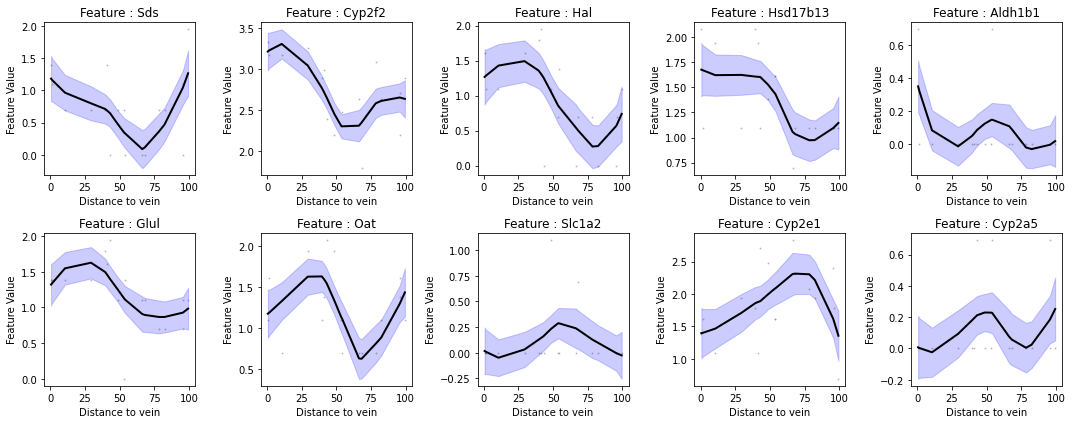

Vein : CN16-E1_67 | P(central) : 0.8636288369041273 | P(portal) : 0.13637116309587272


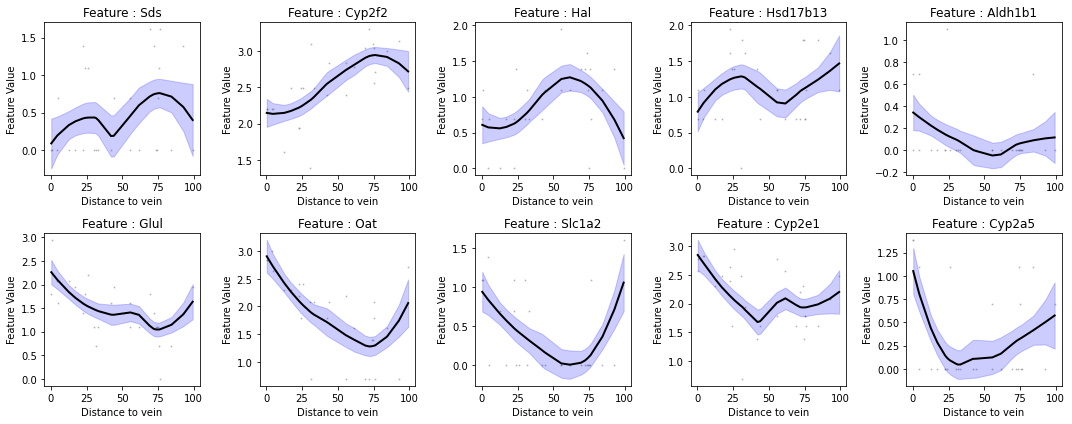

Vein : CN16-E1_68 | P(central) : 0.19953364220099046 | P(portal) : 0.8004663577990095


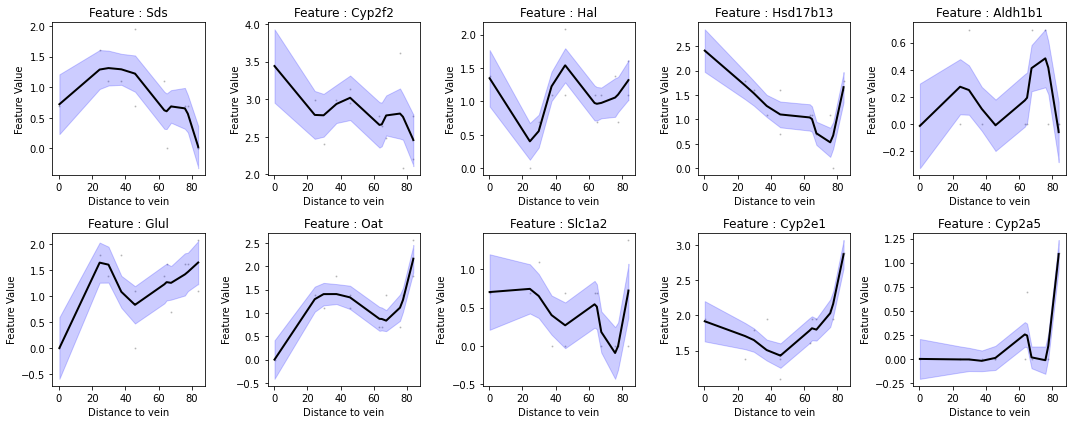

Vein : CN65-D1_5 | P(central) : 0.8633782698498327 | P(portal) : 0.13662173015016732


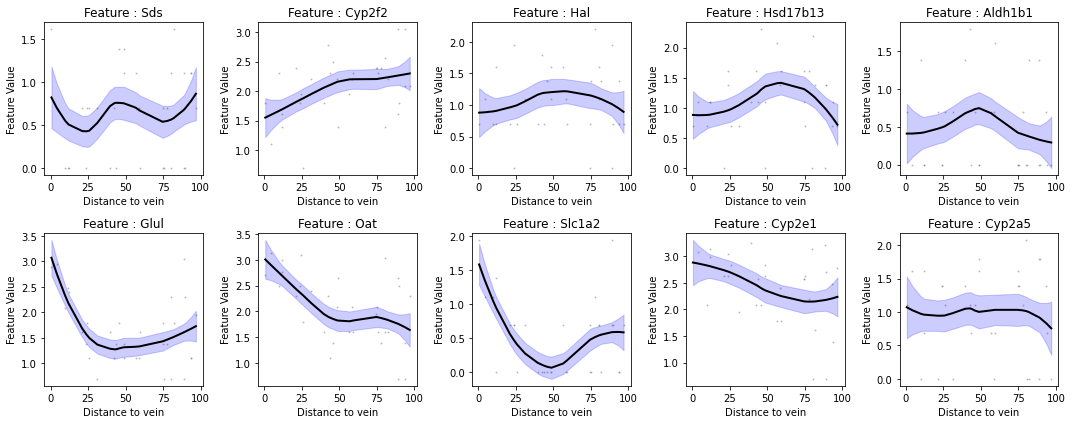

Vein : CN65-D1_6 | P(central) : 0.9225960622658107 | P(portal) : 0.07740393773418931


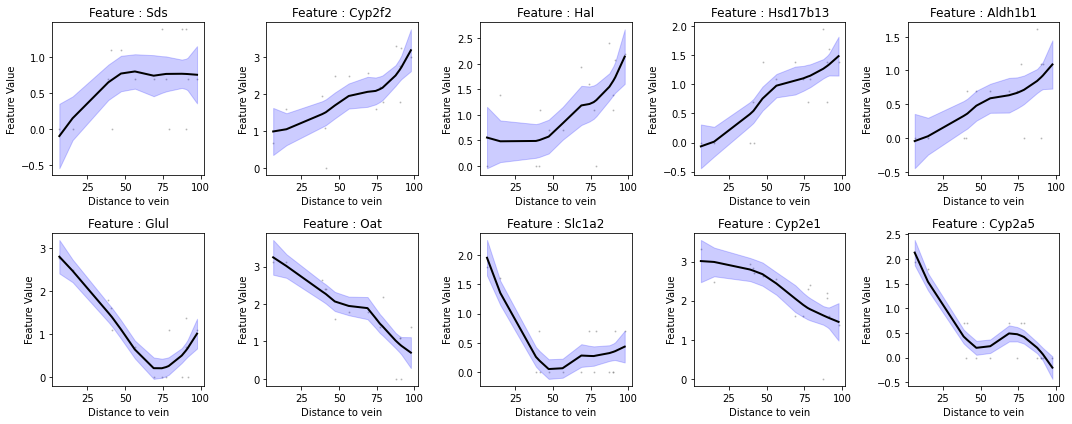

Vein : CN65-D1_7 | P(central) : 0.8481716886524239 | P(portal) : 0.15182831134757613


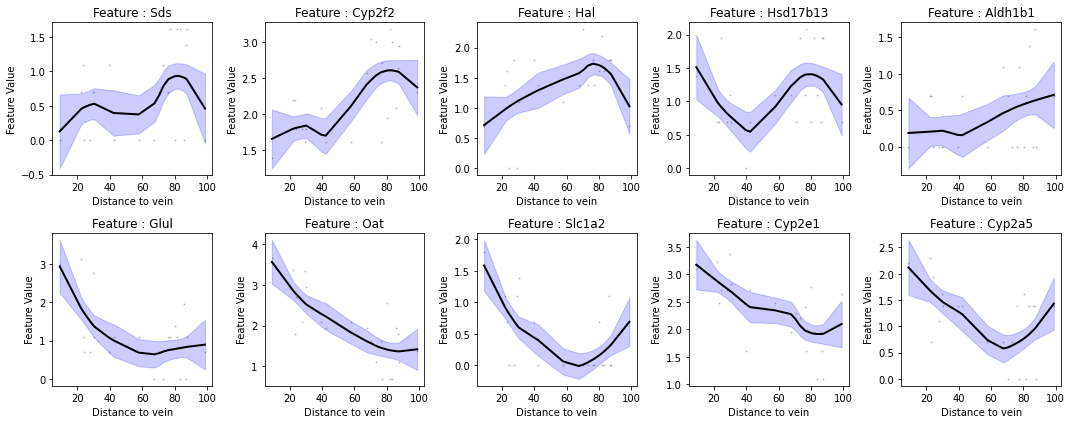

Vein : CN16-D2_19 | P(central) : 0.3129022531339175 | P(portal) : 0.6870977468660825


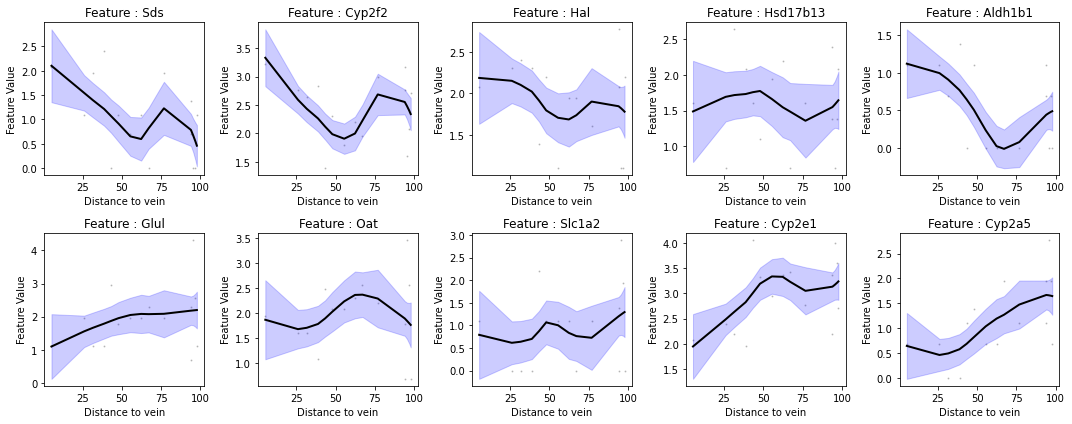

Vein : CN16-D2_20 | P(central) : 0.2964411539349019 | P(portal) : 0.7035588460650981


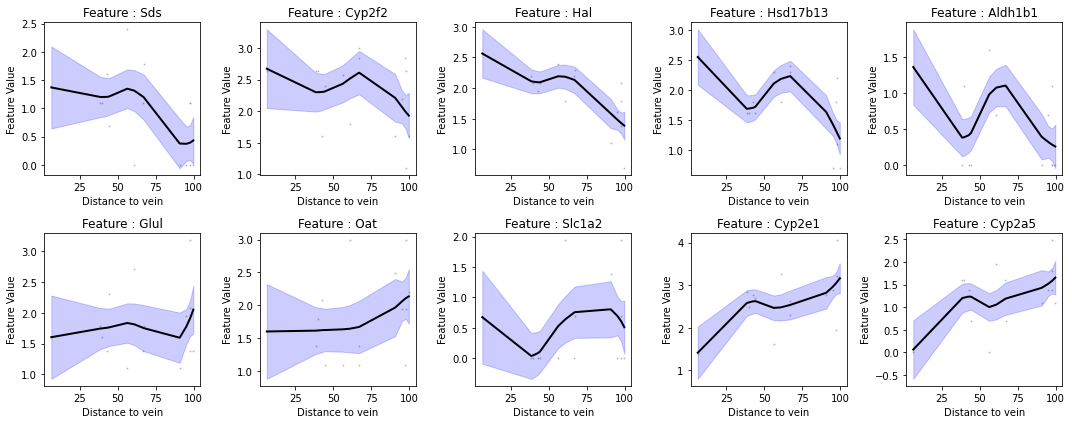

Vein : CN16-D2_21 | P(central) : 0.18312130269576976 | P(portal) : 0.8168786973042302


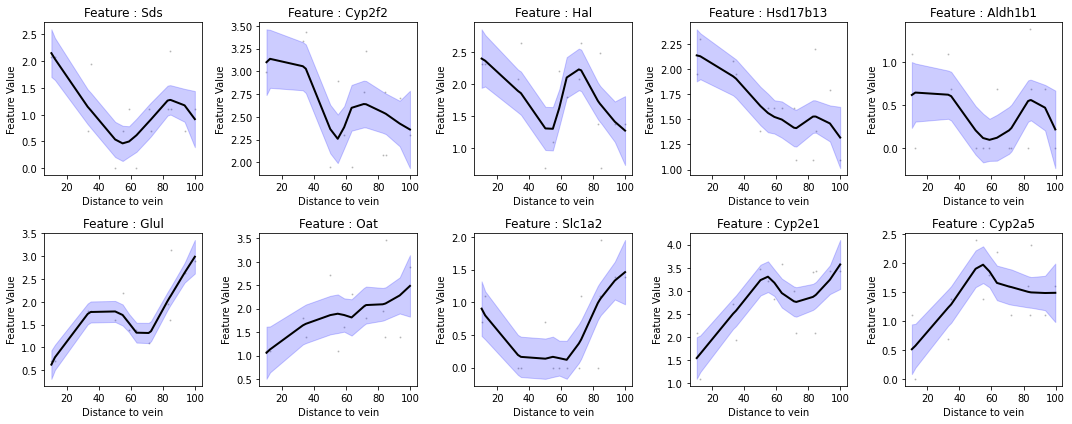

Vein : CN16-D2_22 | P(central) : 0.27310897883685126 | P(portal) : 0.7268910211631487


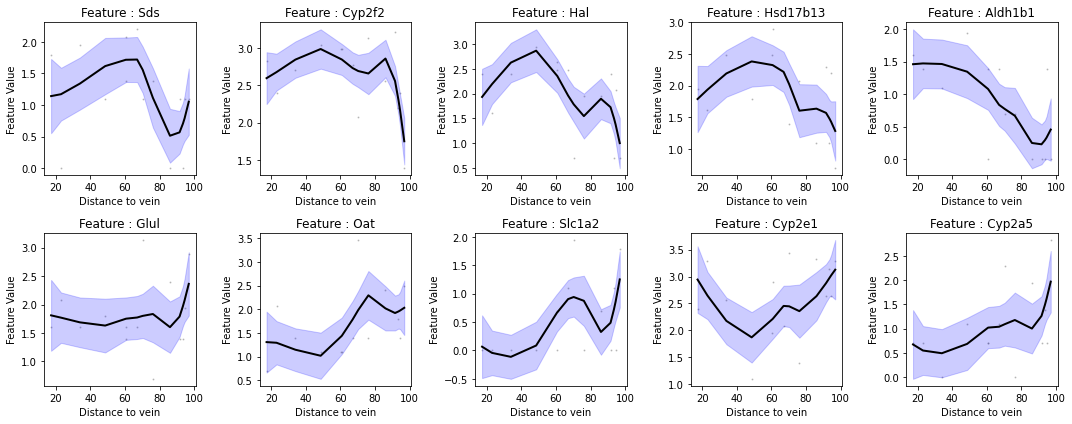

Vein : CN16-D2_23 | P(central) : 0.8338034882398611 | P(portal) : 0.16619651176013892


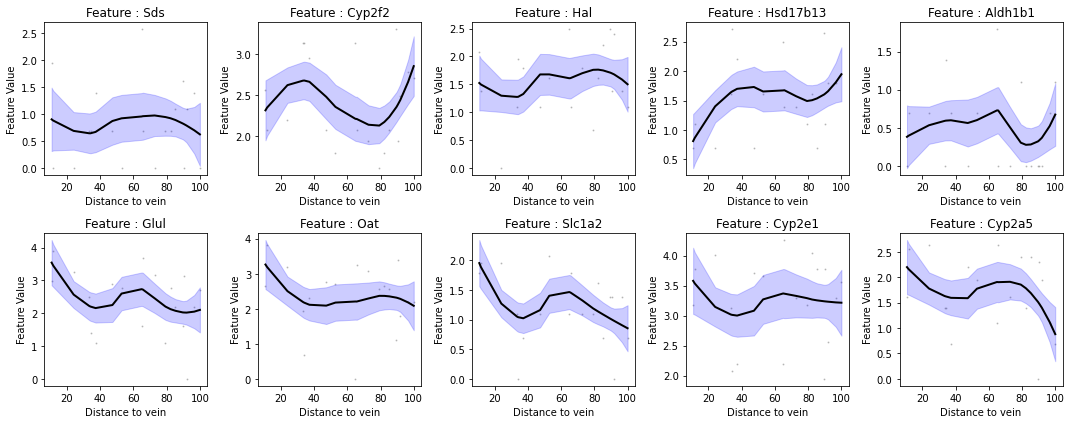

Vein : CN16-D2_24 | P(central) : 0.9092715615811444 | P(portal) : 0.09072843841885564


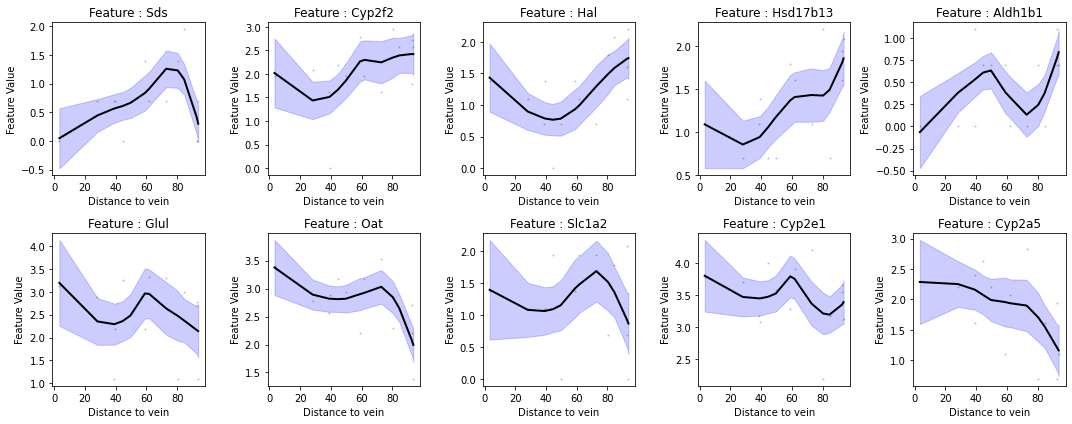

Vein : CN16-E2_12 | P(central) : 0.12378751565536417 | P(portal) : 0.8762124843446358


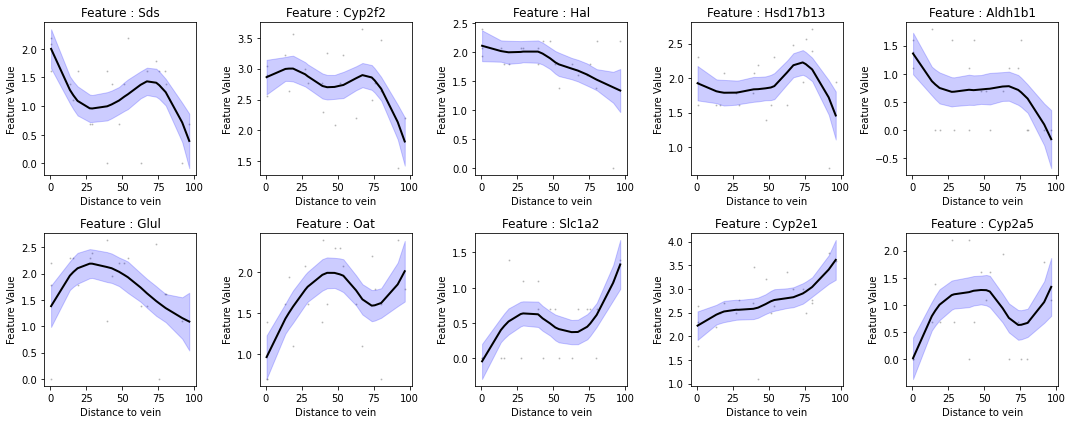

Vein : CN16-E2_13 | P(central) : 0.15546910043884776 | P(portal) : 0.8445308995611522


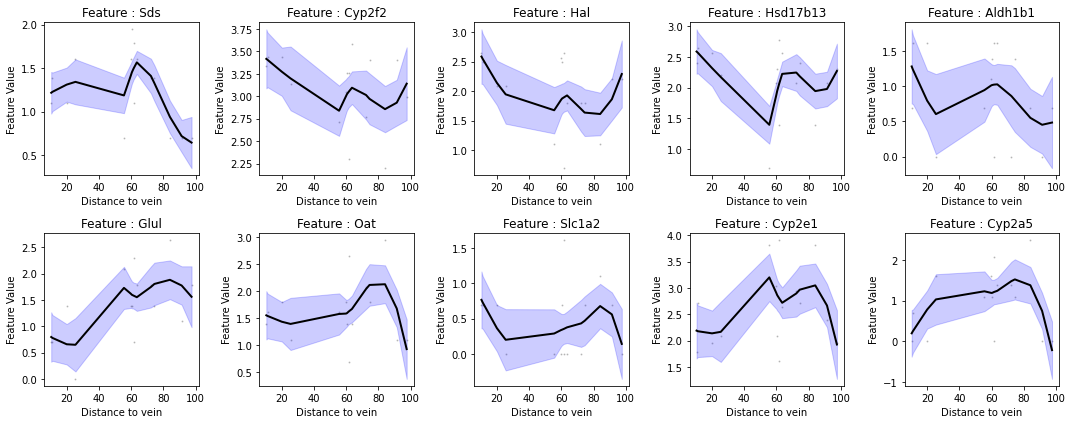

Vein : CN16-E2_14 | P(central) : 0.11645953921004348 | P(portal) : 0.8835404607899565


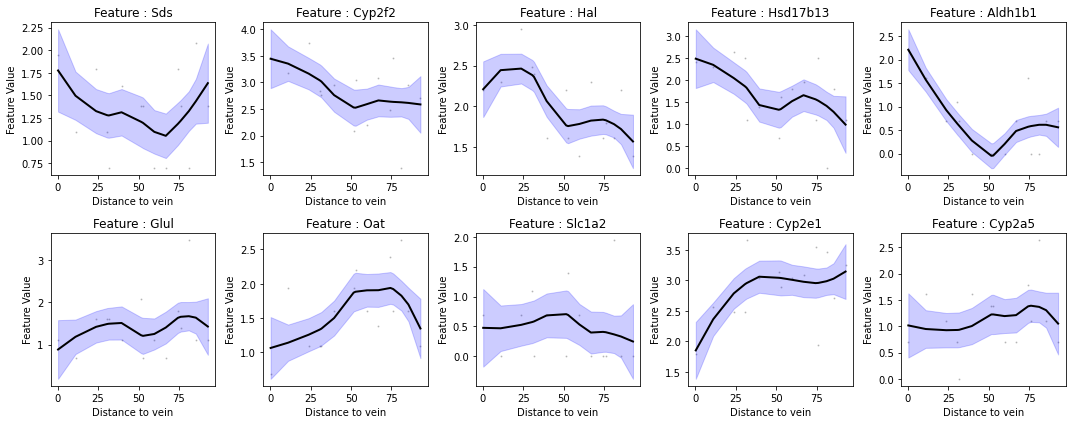

Vein : CN16-E2_15 | P(central) : 0.2758207939408174 | P(portal) : 0.7241792060591826


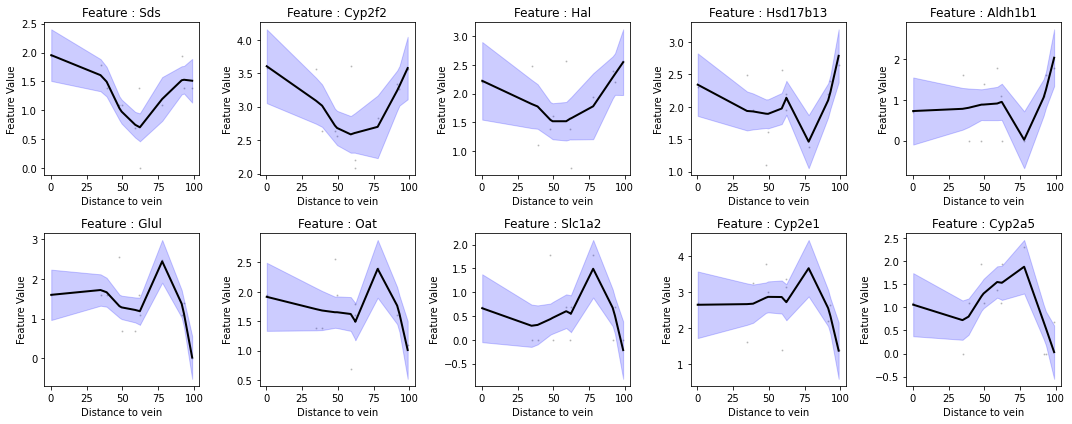

Vein : CN16-E2_16 | P(central) : 0.3397032521289397 | P(portal) : 0.6602967478710603


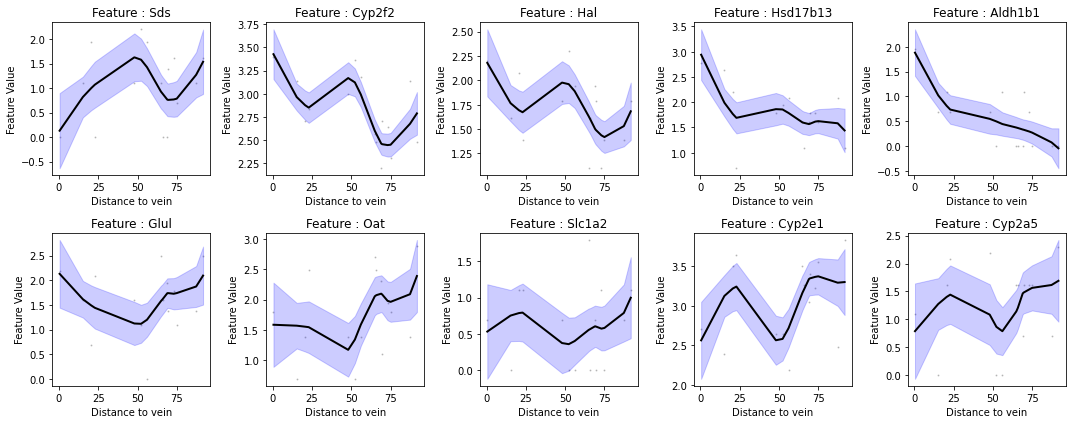

Vein : CN16-E2_17 | P(central) : 0.18254186380184878 | P(portal) : 0.8174581361981512


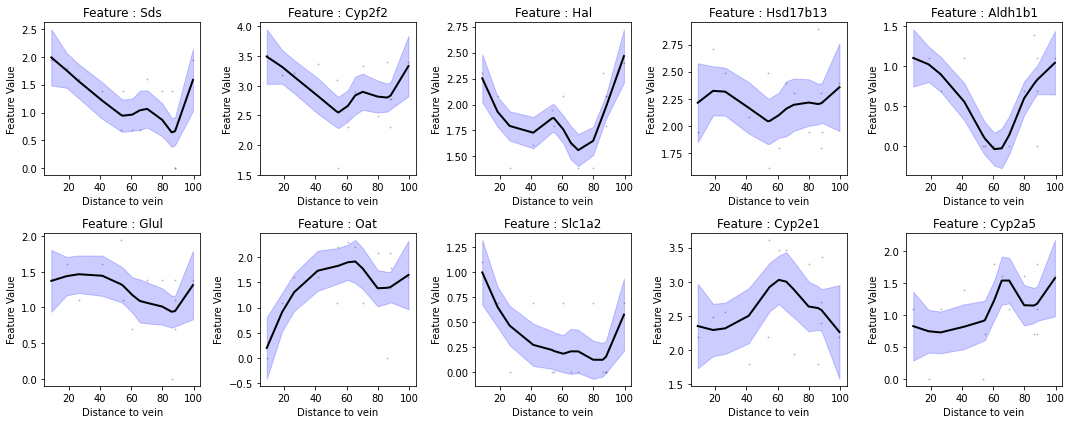

Vein : CN16-E2_18 | P(central) : 0.17765028773682134 | P(portal) : 0.8223497122631787


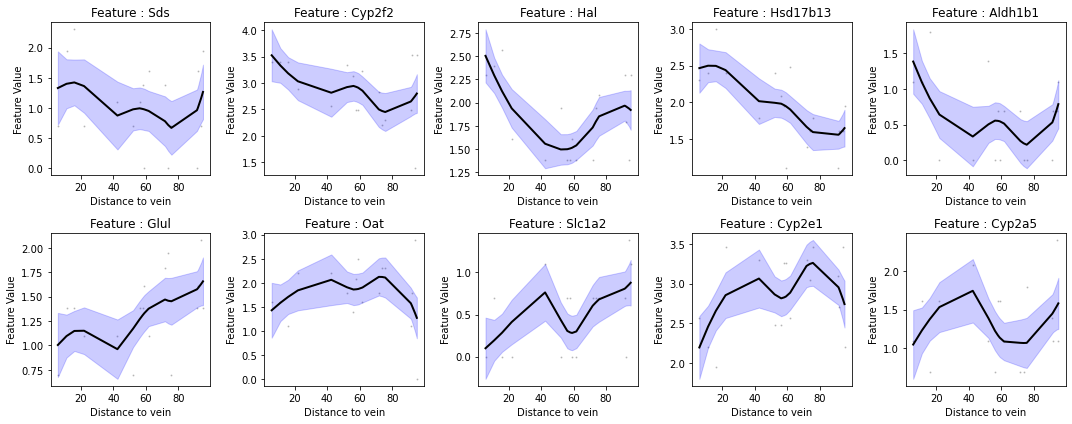

Vein : CN16-E2_19 | P(central) : 0.2741895526097383 | P(portal) : 0.7258104473902617


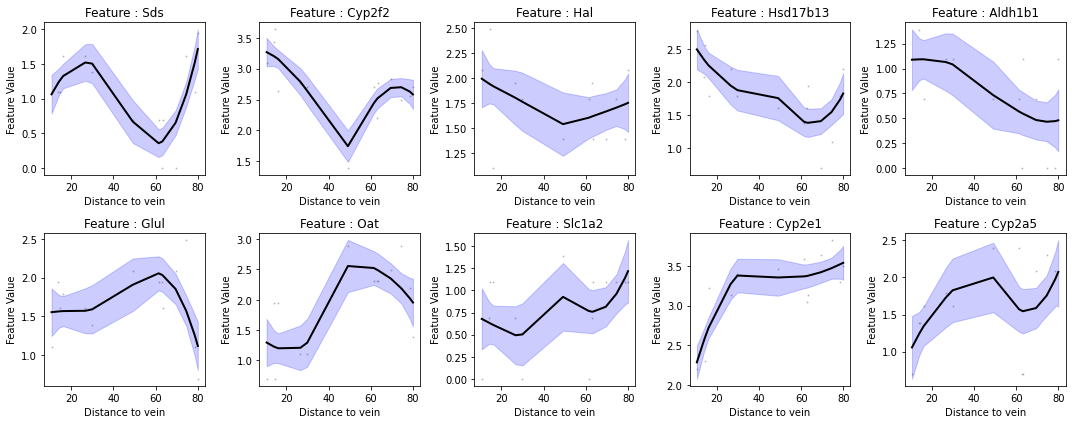

Vein : CN16-E2_20 | P(central) : 0.10126365806534188 | P(portal) : 0.8987363419346581


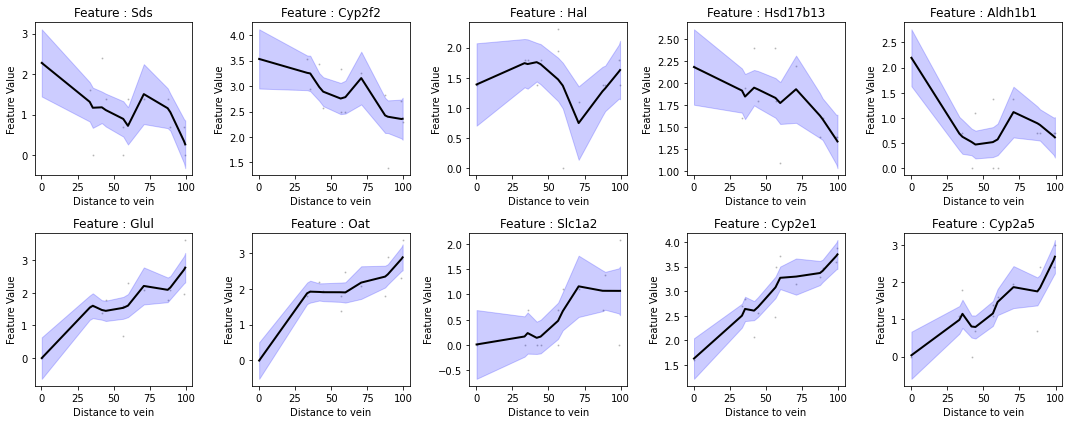

In [268]:


for vein_id in predict.index:
    pc,pp = predict.loc[vein_id,:]
    print("Vein : {} | P(central) : {} | P(portal) : {}".format(vein_id,
                                                                pc,
                                                                pp,
                                                               ))
    fig,ax = ut.get_figure(n_elements=len(vein_genes),
                          n_cols = 5,
                           side_size = 3,
                          )
    
    sample_id = vein_id.split("_")[0]
    
    crd = data_set[sample_id].obs[["x","y"]].values

    dists = vein_data.get_distance_to_vein(crd = crd,
                                           vein_id = vein_id)

    for k,gene in enumerate(vein_genes):
        expr = data_set[sample_id].obs_vector(gene)
        smoothed = ut.smooth_fit(dists,expr,dist_thrs=100)
        
        ut.plot_expression_by_distance(ax[k],
                                       smoothed,
                                       feature = gene,
                                      )
    
    fig.tight_layout()
    plt.show()
        
    

In [269]:
predict_all = model.predict(predict_on="all",
                            return_probs = False,
                        )

predict_all

vein_type
CN73-D1_0    central
CN73-D1_1    central
CN73-D1_2    central
CN73-D1_3     portal
CN73-D1_4     portal
...              ...
CN16-E2_16    portal
CN16-E2_17    portal
CN16-E2_18    portal
CN16-E2_19    portal
CN16-E2_20    portal

[156 rows x 1 columns]

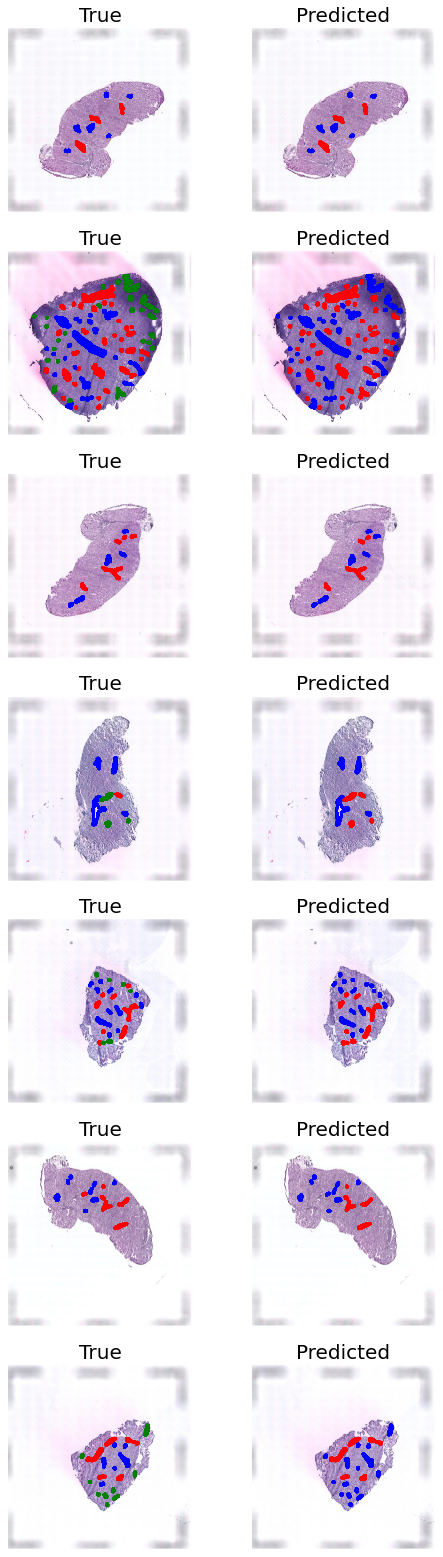

In [270]:
# instantiate plot
fig,ax = plt.subplots(len(data_set),2,
                      figsize = (4 * 2,4 * len(data_set)))

cmap = {"central":"red",
        "portal":"blue",
        "unknown":"green"}


for k,sample_id in enumerate(data_set.keys()):
  
    # convert predicted type to vector
    # with label for each pixel
    
    true_color = data_set[sample_id].uns["mask"].type.map(cmap).values.flatten()
    pred_color = data_set[sample_id].uns["mask"].type.map(cmap).values.flatten()
    
    idxs = data_set[sample_id].uns["mask"].id.values
    
    for idx in np.unique(idxs):
        sel = idxs == idx
        vein_id = sample_id + "_" + str(idx)
        pred_color[sel] = cmap[predict_all.loc[vein_id].values[0]]
        
    
    ut.plot_veins(ax[k,0],
                  data_set[sample_id],
                  alternative_colors = true_color,
                  show_image = True,
                 )
    
    ut.plot_veins(ax[k,1],
                  data_set[sample_id],
                  alternative_colors = pred_color,
                  show_image = True,
                 )
    
    # set titles
    ax[k,0].set_title("True",
                    fontsize = 20,)
    ax[k,1].set_title("Predicted",
                    fontsize = 20,)
    
    ax[k,0].set_ylabel(sample_id,
                       fontsize = 20)



plt.show()